In [1]:
INPUT_SHAPE = (1400, 2100)
p_input = '/kaggle/input/understanding_cloud_organization'

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.data import imread


In [3]:
df = pd.read_csv(f'{p_input}/train.csv')
df.shape

(22184, 2)

In [4]:
df['Image'] = df.Image_Label.apply(lambda x: x.split('_')[0])
df.head()

,Image_Label,EncodedPixels,Image
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg
2,0011165.jpg_Gravel,NaN,0011165.jpg
3,0011165.jpg_Sugar,NaN,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg


In [5]:
def rle2mask(mask_rle, shape=INPUT_SHAPE):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img_msk = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img_msk[lo:hi] = 1
    return img_msk.reshape(shape, order='F')  # Needed to align to RLE direction

# https://www.kaggle.com/xhlulu/satellite-clouds-u-net-with-resnet-encoder
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

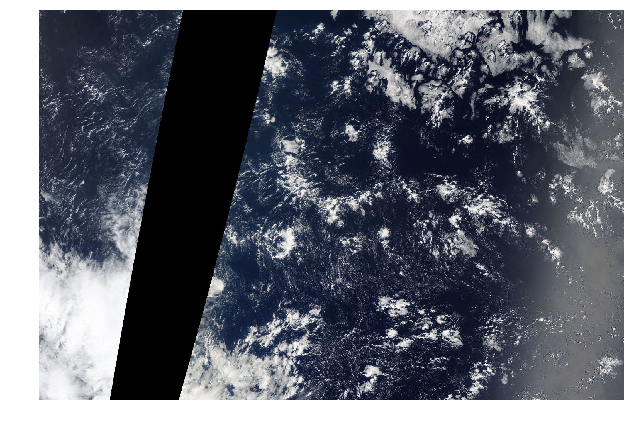

In [6]:
fn_img, mask_rle = df[['Image', 'EncodedPixels']][df.EncodedPixels.notnull()].sample().values[0]
img = imread(f'{p_input}/train_images/{fn_img}')   
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.axis('off')
ax.imshow(img)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [7]:
img.shape, img.sum(-1).shape, img.mean(), (img.sum(-1)==0).mean()

((1400, 2100, 3), (1400, 2100), 74.34791020408163, 0.13706462585034013)

In [8]:
mask_rle = df.EncodedPixels[df.EncodedPixels.notnull()].sample().values[0]
assert mask_rle==mask2rle(rle2mask(mask_rle))
mask = rle2mask(mask_rle)
assert np.all(mask==rle2mask(mask2rle(mask)))

In [9]:
def rle2box(mask_rle, shape=INPUT_SHAPE):
    img_msk = rle2mask(mask_rle)
    [(y_1, y_2), (x_1, x_2)]= [(o.min(), o.max()) for o in np.where(img_msk==1)]
    return x_1, y_1, x_2, y_2

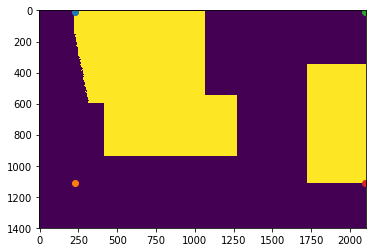

In [10]:
box = x_1, y_1, x_2, y_2 = rle2box(mask_rle)
plt.imshow(mask);
plt.plot(x_1, y_1, 'o');
plt.plot(x_1, y_2, 'o');
plt.plot(x_2, y_1, 'o');
plt.plot(x_2, y_2, 'o');

In [11]:
def box2mask(box, shape=INPUT_SHAPE):
    x_1, y_1, x_2, y_2 = box
    mask = np.zeros(shape)
    mask[y_1:y_2, x_1:x_2]=1
    return mask

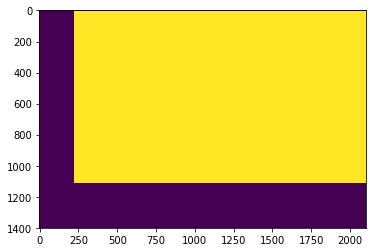

In [12]:
mask = box2mask(box)
plt.imshow(mask);

In [13]:
def box2rle(box, shape=INPUT_SHAPE, img=None):
    mask = box2mask(box, shape)
    if img is not None: mask[img.sum(-1)==0]=0
    mask_rle = mask2rle(mask)
    return mask_rle

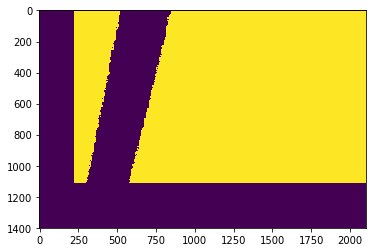

In [14]:
mask_rle_recovered = box2rle(box, img=img)
mask_recovered = rle2mask(mask_rle_recovered)
plt.imshow(mask_recovered);